# 🌍 Comprehensive Ionosphere Data Analysis

Complete analysis including:
- ✅ Original scale conditions (using revert function)
- ✅ Temporal evolution analysis
- ✅ Polar coordinate visualizations
- ✅ Max-Min difference tracking (WANDB metric)
- ✅ Statistical analysis and correlations

## 📚 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import random
from datetime import datetime
import warnings
import sys
from scipy.interpolate import griddata
warnings.filterwarnings('ignore')

# Add project path
sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere')

# Import polar visualization utilities
from util import (
    plot_polar_ionosphere_single,
    plot_polar_ionosphere_comparison, 
    plot_polar_ionosphere_batch
)

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

print("🚀 Libraries and utilities imported successfully!")
print("📊 Ready for comprehensive ionosphere analysis!")

🚀 Libraries and utilities imported successfully!
📊 Ready for comprehensive ionosphere analysis!


## 🗄️ 2. Dataset Loading and Configuration

In [2]:
# Dataset configuration
csv_path = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/npy_metrics.csv"
transform_cond_csv = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv"

# Import dataset classes
from src.data.dataset import get_sequence_data_objects

print(f"📂 Dataset Configuration:")
print(f"  Main CSV: {csv_path}")
print(f"  Condition CSV: {transform_cond_csv}")

# Load train dataset
print(f"\n🔄 Loading dataset...")
dataset, sampler, dataloader = get_sequence_data_objects(
    csv_path=csv_path,
    transform_cond_csv=transform_cond_csv,
    batch_size=1,
    distributed=False,
    num_data_workers=0,
    split='train',
    seed=42,
    sequence_length=16
)

print(f"\n✅ Dataset loaded successfully!")
print(f"  📊 Total sequences: {len(dataset)}")
print(f"  🕒 Sequence length: 16 timesteps")
print(f"  🗺️ Data resolution: (24, 360) - lat/lon grid")

print(f"\n🎯 Condition normalization parameters:")
print(f"  Min values: {dataset.cond_min}")
print(f"  Max values: {dataset.cond_max}")
print(f"\n🔧 Revert function available: dataset.revert_condition_normalization()")

📂 Dataset Configuration:
  Main CSV: /mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/npy_metrics.csv
  Condition CSV: /mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv

🔄 Loading dataset...

✅ Dataset loaded successfully!
  📊 Total sequences: 10736
  🕒 Sequence length: 120 timesteps
  🗺️ Data resolution: (24, 360) - lat/lon grid

🎯 Condition normalization parameters:
  Min values: [-42.79 -63.68 -47.85  -0.  ]
  Max values: [  24.14   69.76   52.51 1024.8 ]

🔧 Revert function available: dataset.revert_condition_normalization()


## 📊 3. Comprehensive Statistics Collection

In [3]:
def collect_full_statistics(dataset, split_name='train', max_samples=200):
    """
    Collect comprehensive statistics including original scale conditions and temporal analysis
    """
    stats = {
        # Data statistics (normalized and original)
        'data_min_norm': [], 'data_max_norm': [], 'data_mean_norm': [], 'data_std_norm': [],
        'data_min_orig': [], 'data_max_orig': [], 'data_mean_orig': [], 'data_std_orig': [],
        'max_min_diff': [],
        
        # Condition statistics (normalized [-1,1] and original scale)
        'conditions_normalized': [], 'conditions_original': [],
        
        # Temporal statistics
        'temporal_variance': [], 'temporal_range': [], 'temporal_mean_change': [],
        'temporal_max_min_range': [], 'condition_changes': []
    }
    
    print(f"🔍 Collecting comprehensive statistics for {split_name} dataset...")
    print(f"📈 Will analyze {max_samples} random samples")
    print(f"🎯 Including original scale conditions and temporal evolution")
    
    # Sample random indices
    indices = random.sample(range(len(dataset)), min(max_samples, len(dataset)))
    
    for i, idx in enumerate(indices):
        if i % 25 == 0:
            print(f"  📊 Processing sample {i+1}/{len(indices)}...")
            
        data_seq, cond_seq = dataset[idx]
        seq_length = data_seq.shape[0]
        
        # === DATA STATISTICS ===
        # Normalized data
        stats['data_min_norm'].append(data_seq.min().item())
        stats['data_max_norm'].append(data_seq.max().item())
        stats['data_mean_norm'].append(data_seq.mean().item())
        stats['data_std_norm'].append(data_seq.std().item())
        
        # Original scale data
        data_orig = data_seq * 108154.0
        stats['data_min_orig'].append(data_orig.min().item())
        stats['data_max_orig'].append(data_orig.max().item())
        stats['data_mean_orig'].append(data_orig.mean().item())
        stats['data_std_orig'].append(data_orig.std().item())
        stats['max_min_diff'].append((data_orig.max() - data_orig.min()).item())
        
        # === CONDITION STATISTICS ===
        # Use first timestep for conditions
        cond_norm = cond_seq[0].numpy()  # Normalized [-1, 1]
        cond_orig = dataset.revert_condition_normalization(cond_seq[0]).numpy()  # Original scale
        
        stats['conditions_normalized'].append(cond_norm)
        stats['conditions_original'].append(cond_orig)
        
        # === TEMPORAL STATISTICS ===
        # Calculate temporal evolution statistics
        temporal_means = [data_orig[t].mean().item() for t in range(seq_length)]
        temporal_max_mins = [(data_orig[t].max() - data_orig[t].min()).item() for t in range(seq_length)]
        
        stats['temporal_variance'].append(np.var(temporal_means))
        stats['temporal_range'].append(max(temporal_means) - min(temporal_means))
        stats['temporal_mean_change'].append(abs(temporal_means[-1] - temporal_means[0]))
        stats['temporal_max_min_range'].append(max(temporal_max_mins) - min(temporal_max_mins))
        
        # Condition changes over time (original scale)
        cond_orig_first = dataset.revert_condition_normalization(cond_seq[0]).numpy()
        cond_orig_last = dataset.revert_condition_normalization(cond_seq[-1]).numpy()
        condition_changes = np.abs(cond_orig_last - cond_orig_first)
        stats['condition_changes'].append(condition_changes)
    
    # Convert to numpy arrays
    for key in stats:
        stats[key] = np.array(stats[key])
    
    print(f"\n✅ Statistics collection complete!")
    print(f"  📊 Analyzed {len(indices)} samples")
    print(f"  🎯 Both normalized and original scale conditions included")
    print(f"  ⏰ Temporal evolution statistics computed")
    
    return stats

# Collect comprehensive statistics
train_stats = collect_full_statistics(dataset, 'train', max_samples=200)

🔍 Collecting comprehensive statistics for train dataset...
📈 Will analyze 200 random samples
🎯 Including original scale conditions and temporal evolution
  📊 Processing sample 1/200...
  📊 Processing sample 26/200...
  📊 Processing sample 51/200...
  📊 Processing sample 76/200...
  📊 Processing sample 101/200...
  📊 Processing sample 126/200...
  📊 Processing sample 151/200...
  📊 Processing sample 176/200...

✅ Statistics collection complete!
  📊 Analyzed 200 samples
  🎯 Both normalized and original scale conditions included
  ⏰ Temporal evolution statistics computed


## 📈 4. Statistical Summary with Original Scale Conditions

In [4]:
def print_comprehensive_statistics(stats, dataset):
    print(f"\n{'='*80}")
    print(f"🌍 COMPREHENSIVE IONOSPHERE DATA STATISTICS")
    print(f"{'='*80}")
    
    print(f"\n📊 DATA STATISTICS:")
    print(f"  Normalized (÷108154.0): [{stats['data_min_norm'].min():.6f}, {stats['data_max_norm'].max():.6f}]")
    print(f"  Original (×108154.0):   [{stats['data_min_orig'].min():.1f}, {stats['data_max_orig'].max():.1f}]")
    print(f"  Mean (original): {stats['data_mean_orig'].mean():.1f} ± {stats['data_mean_orig'].std():.1f}")
    
    print(f"\n🎯 MAX-MIN DIFFERENCE (WANDB METRIC):")
    print(f"  Mean: {stats['max_min_diff'].mean():.1f}")
    print(f"  Std:  {stats['max_min_diff'].std():.1f}")
    print(f"  Range: [{stats['max_min_diff'].min():.1f}, {stats['max_min_diff'].max():.1f}]")
    print(f"  Median: {np.median(stats['max_min_diff']):.1f}")
    
    print(f"\n🔥 CONDITION PARAMETERS:")
    param_names = ['Float1', 'Float2', 'Float3', 'Float4 (velocity)']
    
    print(f"\n  📐 Normalized [-1, 1]:")
    for i in range(4):
        vals = stats['conditions_normalized'][:, i]
        print(f"    {param_names[i]:20}: [{vals.min():+.3f}, {vals.max():+.3f}], μ={vals.mean():+.3f}")
    
    print(f"\n  🌟 Original Scale:")
    for i in range(4):
        vals = stats['conditions_original'][:, i]
        print(f"    {param_names[i]:20}: [{vals.min():+.3f}, {vals.max():+.3f}], μ={vals.mean():+.3f}")
    
    print(f"\n⏰ TEMPORAL EVOLUTION STATISTICS:")
    print(f"  Temporal variance: {stats['temporal_variance'].mean():.1f} ± {stats['temporal_variance'].std():.1f}")
    print(f"  Temporal range: {stats['temporal_range'].mean():.1f} ± {stats['temporal_range'].std():.1f}")
    print(f"  Mean change over sequence: {stats['temporal_mean_change'].mean():.1f} ± {stats['temporal_mean_change'].std():.1f}")
    print(f"  Max-Min range over time: {stats['temporal_max_min_range'].mean():.1f} ± {stats['temporal_max_min_range'].std():.1f}")
    
    print(f"\n🔄 CONDITION CHANGES OVER TIME (Original Scale):")
    for i in range(4):
        changes = stats['condition_changes'][:, i]
        print(f"  {param_names[i]:20}: {changes.mean():.3f} ± {changes.std():.3f} (avg change per sequence)")
    
    print(f"\n✅ VALIDATION:")
    print(f"  Normalized conditions in [-1,1]: ", end="")
    all_in_range = True
    for i in range(4):
        vals = stats['conditions_normalized'][:, i]
        in_range = np.all((vals >= -1.001) & (vals <= 1.001))
        print(f"P{i+1}:{'✓' if in_range else '✗'} ", end="")
        all_in_range &= in_range
    print(f"\n  Dataset normalization bounds: {dataset.cond_min} → {dataset.cond_max}")
    print(f"  Reversion function: {'✅ Working correctly' if all_in_range else '❌ Check normalization'}")

print_comprehensive_statistics(train_stats, dataset)


🌍 COMPREHENSIVE IONOSPHERE DATA STATISTICS

📊 DATA STATISTICS:
  Normalized (÷108154.0): [-0.520077, 0.553158]
  Original (×108154.0):   [-56248.4, 59826.3]
  Mean (original): -791.3 ± 4336.8

🎯 MAX-MIN DIFFERENCE (WANDB METRIC):
  Mean: 41960.0
  Std:  16364.3
  Range: [14228.0, 107108.3]
  Median: 41115.8

🔥 CONDITION PARAMETERS:

  📐 Normalized [-1, 1]:
    Float1              : [+0.032, +0.509], μ=+0.256
    Float2              : [-0.277, +0.203], μ=-0.037
    Float3              : [-0.321, +0.167], μ=-0.055
    Float4 (velocity)   : [-1.000, +0.145], μ=-0.448

  🌟 Original Scale:
    Float1              : [-8.260, +7.720], μ=-0.769
    Float2              : [-15.470, +16.600], μ=+0.603
    Float3              : [-13.780, +10.690], μ=-0.428
    Float4 (velocity)   : [+0.000, +586.500], μ=+282.901

⏰ TEMPORAL EVOLUTION STATISTICS:
  Temporal variance: 3597975.8 ± 5558031.5
  Temporal range: 5471.1 ± 3429.3
  Mean change over sequence: 2655.5 ± 2842.0
  Max-Min range over time: 1429

## 📊 5. Distribution Analysis - Original vs Normalized Conditions

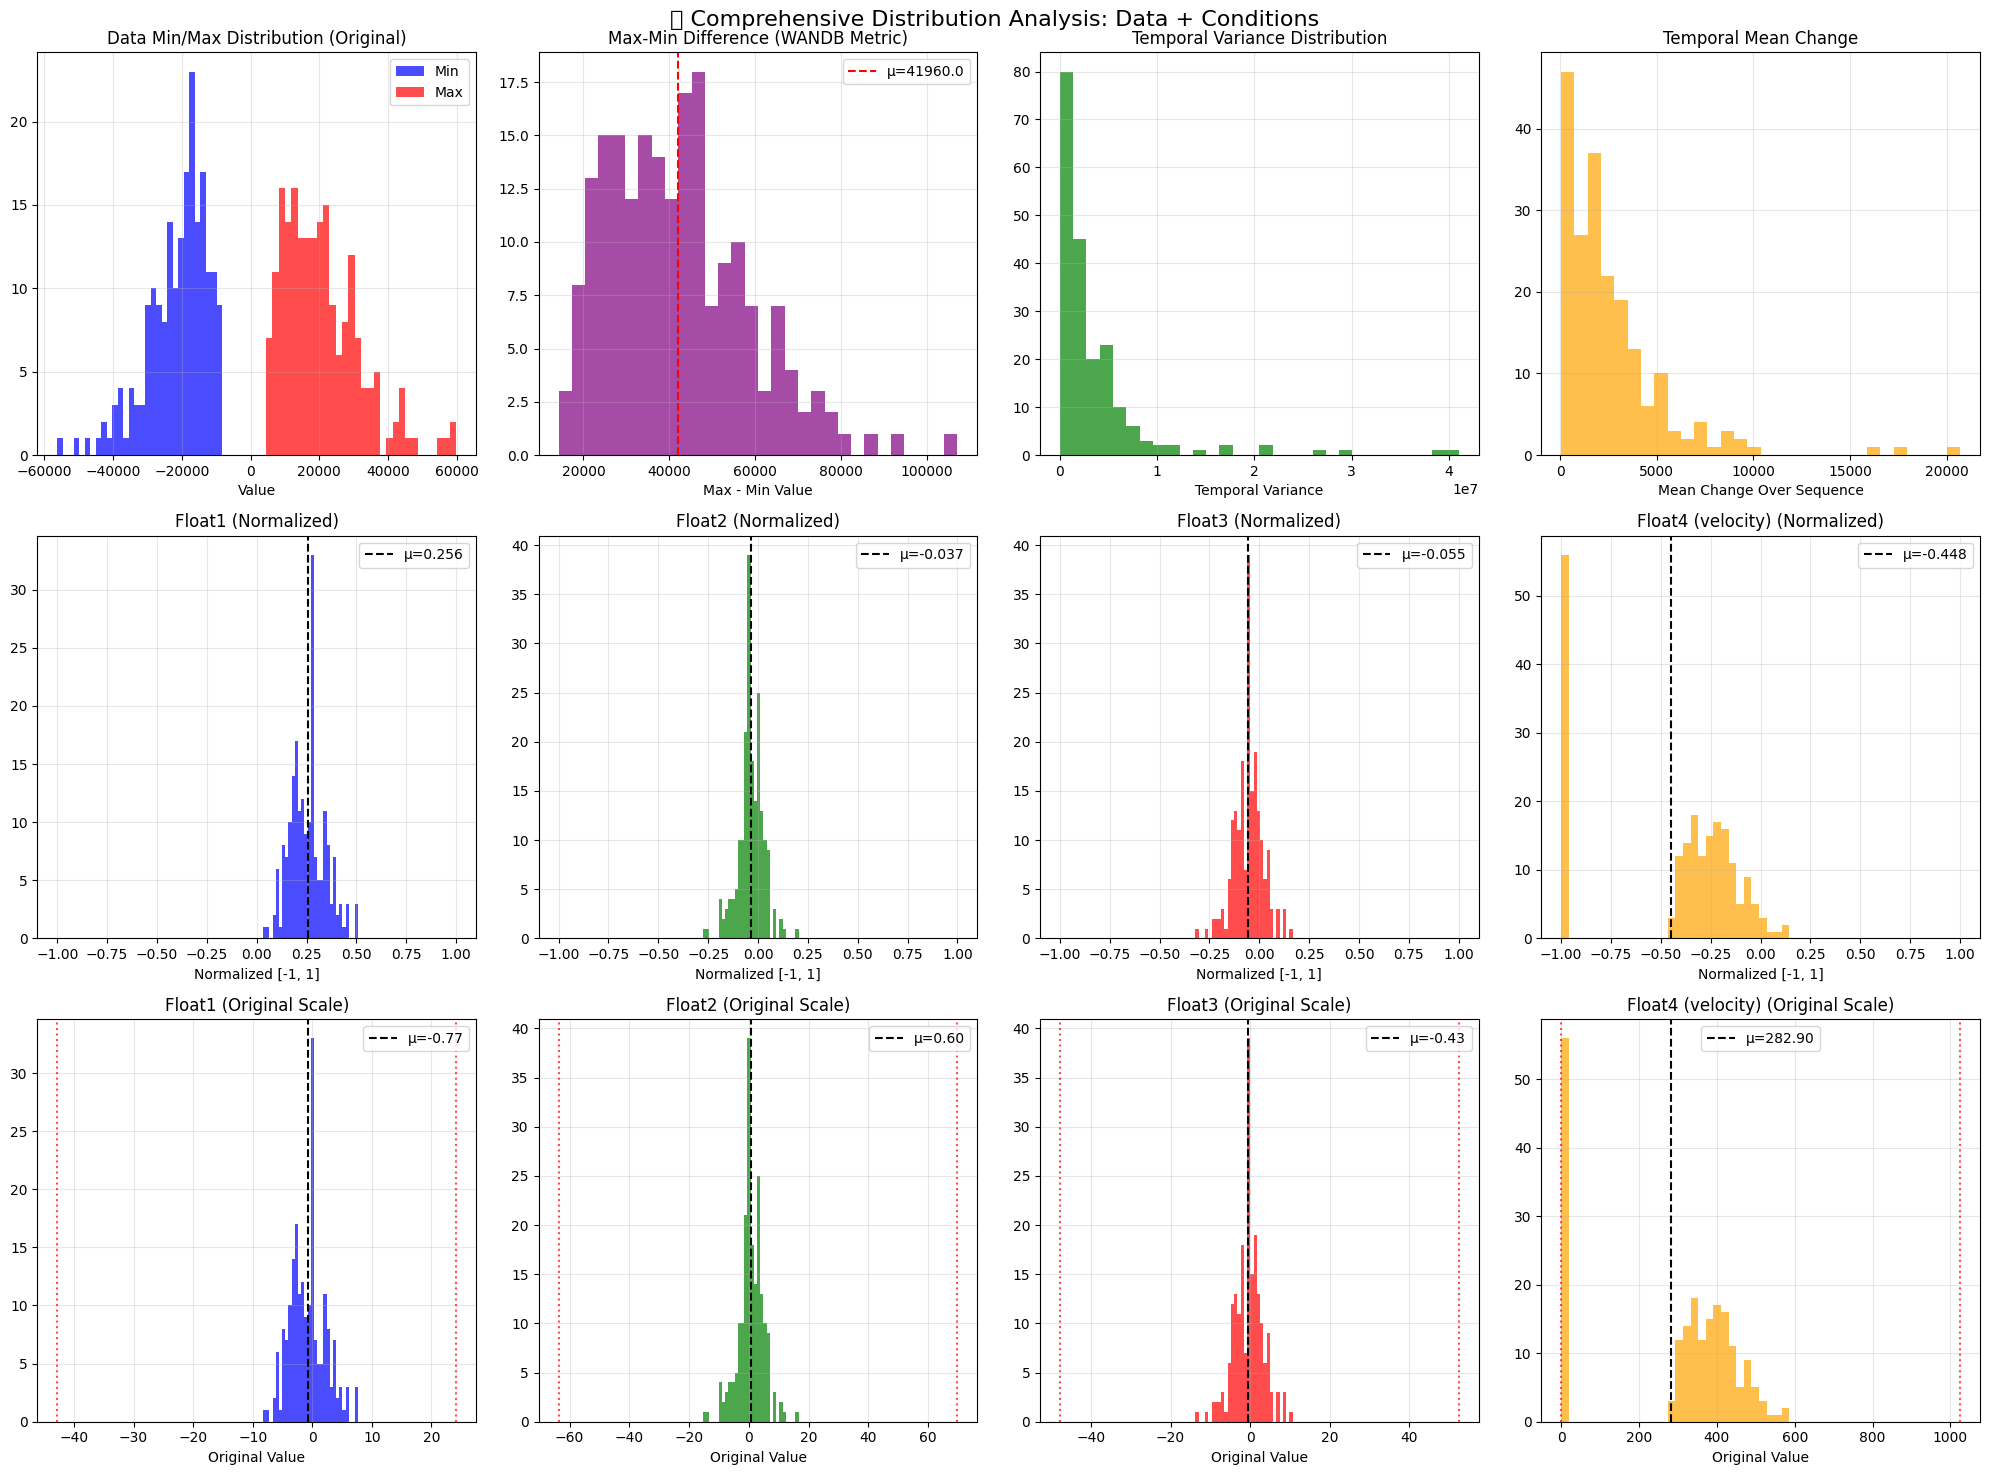


📊 Distribution analysis complete!
  🔝 Top row: Data statistics and temporal metrics
  🔄 Middle row: Normalized conditions [-1, 1]
  🌟 Bottom row: Original scale conditions
  🔍 Red dotted lines: Dataset normalization bounds


In [5]:
# Comprehensive distribution analysis
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('🌍 Comprehensive Distribution Analysis: Data + Conditions', fontsize=16, y=0.98)

# Row 1: Data distributions
# Data min/max (original scale)
axes[0, 0].hist(train_stats['data_min_orig'], bins=30, alpha=0.7, color='blue', label='Min')
axes[0, 0].hist(train_stats['data_max_orig'], bins=30, alpha=0.7, color='red', label='Max')
axes[0, 0].set_title('Data Min/Max Distribution (Original)')
axes[0, 0].set_xlabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Max-Min difference (WANDB metric)
axes[0, 1].hist(train_stats['max_min_diff'], bins=30, alpha=0.7, color='purple')
axes[0, 1].axvline(train_stats['max_min_diff'].mean(), color='red', linestyle='--', 
                   label=f"μ={train_stats['max_min_diff'].mean():.1f}")
axes[0, 1].set_title('Max-Min Difference (WANDB Metric)')
axes[0, 1].set_xlabel('Max - Min Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Temporal statistics
axes[0, 2].hist(train_stats['temporal_variance'], bins=30, alpha=0.7, color='green')
axes[0, 2].set_title('Temporal Variance Distribution')
axes[0, 2].set_xlabel('Temporal Variance')
axes[0, 2].grid(True, alpha=0.3)

axes[0, 3].hist(train_stats['temporal_mean_change'], bins=30, alpha=0.7, color='orange')
axes[0, 3].set_title('Temporal Mean Change')
axes[0, 3].set_xlabel('Mean Change Over Sequence')
axes[0, 3].grid(True, alpha=0.3)

# Row 2: Normalized conditions [-1, 1]
param_names = ['Float1', 'Float2', 'Float3', 'Float4 (velocity)']
colors = ['blue', 'green', 'red', 'orange']

for i in range(4):
    cond_values = train_stats['conditions_normalized'][:, i]
    axes[1, i].hist(cond_values, bins=30, alpha=0.7, color=colors[i])
    axes[1, i].axvline(cond_values.mean(), color='black', linestyle='--', 
                       label=f'μ={cond_values.mean():.3f}')
    axes[1, i].set_title(f'{param_names[i]} (Normalized)')
    axes[1, i].set_xlabel('Normalized [-1, 1]')
    axes[1, i].set_xlim(-1.1, 1.1)
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

# Row 3: Original scale conditions
for i in range(4):
    cond_values = train_stats['conditions_original'][:, i]
    axes[2, i].hist(cond_values, bins=30, alpha=0.7, color=colors[i])
    axes[2, i].axvline(cond_values.mean(), color='black', linestyle='--', 
                       label=f'μ={cond_values.mean():.2f}')
    axes[2, i].set_title(f'{param_names[i]} (Original Scale)')
    axes[2, i].set_xlabel('Original Value')
    axes[2, i].legend()
    axes[2, i].grid(True, alpha=0.3)
    
    # Add dataset bounds for verification
    axes[2, i].axvline(dataset.cond_min[i], color='red', linestyle=':', alpha=0.7, label='Dataset Min')
    axes[2, i].axvline(dataset.cond_max[i], color='red', linestyle=':', alpha=0.7, label='Dataset Max')

plt.tight_layout()
plt.show()

print("\n📊 Distribution analysis complete!")
print("  🔝 Top row: Data statistics and temporal metrics")
print("  🔄 Middle row: Normalized conditions [-1, 1]")
print("  🌟 Bottom row: Original scale conditions")
print("  🔍 Red dotted lines: Dataset normalization bounds")

## 🔗 6. Correlation Analysis - Original Scale Focus

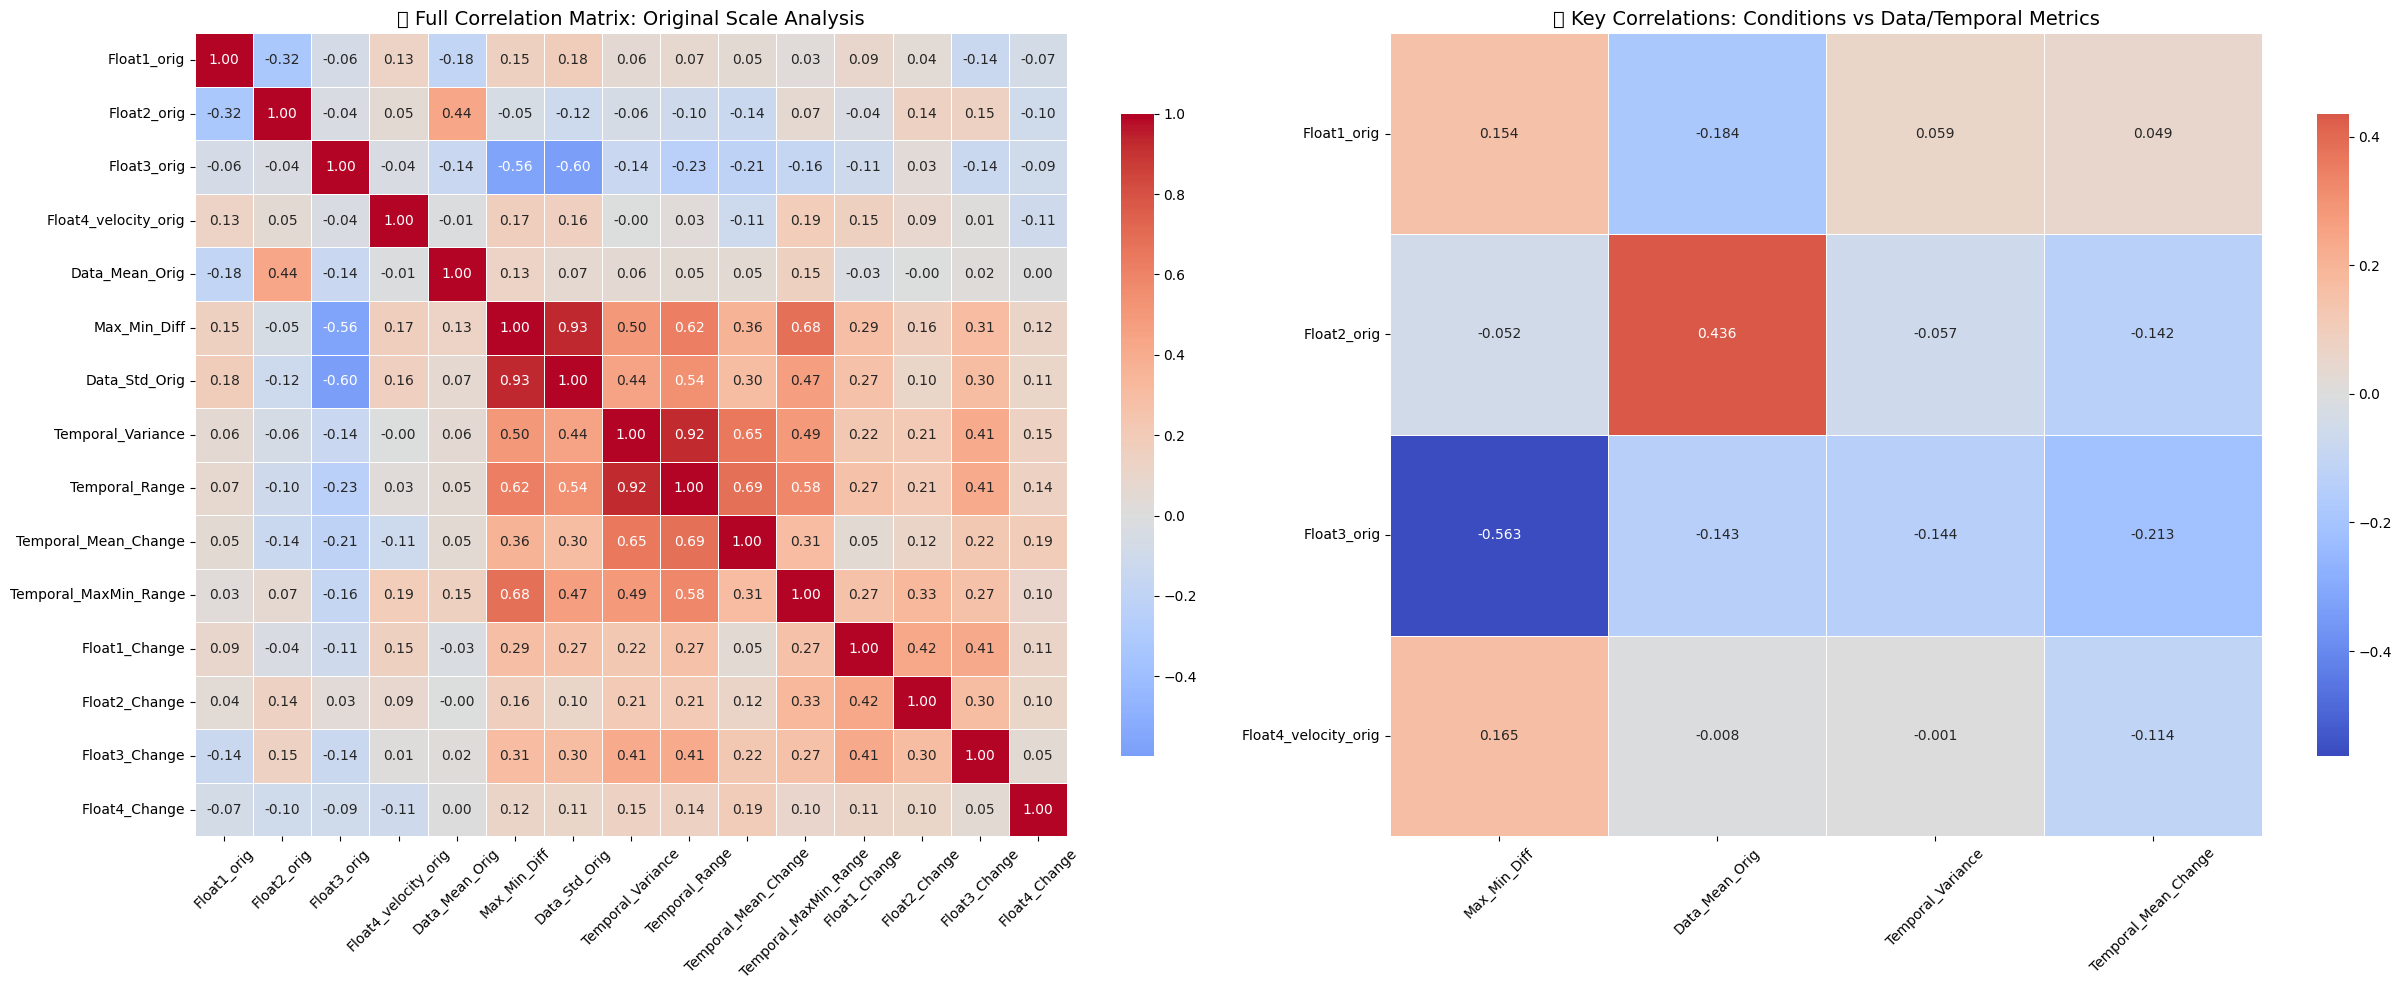


🔗 KEY CORRELATION INSIGHTS:

🎯 Original Scale Conditions vs WANDB Metric (Max-Min Diff):
  Float1_orig         : +0.154 (Weak)
  Float2_orig         : -0.052 (Weak)
  Float3_orig         : -0.563 (Strong)
  Float4_velocity_orig: +0.165 (Weak)

⏰ Original Conditions vs Temporal Metrics:
  Float3_orig vs Temporal_Mean_Change: -0.213

🔄 Strongest Overall Correlations:
  Max_Min_Diff <-> Data_Std_Orig: +0.928
  Temporal_Range <-> Temporal_Variance: +0.920
  Temporal_Mean_Change <-> Temporal_Range: +0.686
  Temporal_MaxMin_Range <-> Max_Min_Diff: +0.676
  Temporal_Mean_Change <-> Temporal_Variance: +0.650


In [6]:
# Create comprehensive correlation analysis
corr_df = pd.DataFrame()

# Original scale conditions (primary focus)
corr_df['Float1_orig'] = train_stats['conditions_original'][:, 0]
corr_df['Float2_orig'] = train_stats['conditions_original'][:, 1]
corr_df['Float3_orig'] = train_stats['conditions_original'][:, 2]
corr_df['Float4_velocity_orig'] = train_stats['conditions_original'][:, 3]

# Data metrics
corr_df['Data_Mean_Orig'] = train_stats['data_mean_orig']
corr_df['Max_Min_Diff'] = train_stats['max_min_diff']
corr_df['Data_Std_Orig'] = train_stats['data_std_orig']

# Temporal metrics
corr_df['Temporal_Variance'] = train_stats['temporal_variance']
corr_df['Temporal_Range'] = train_stats['temporal_range']
corr_df['Temporal_Mean_Change'] = train_stats['temporal_mean_change']
corr_df['Temporal_MaxMin_Range'] = train_stats['temporal_max_min_range']

# Condition changes over time
corr_df['Float1_Change'] = train_stats['condition_changes'][:, 0]
corr_df['Float2_Change'] = train_stats['condition_changes'][:, 1]
corr_df['Float3_Change'] = train_stats['condition_changes'][:, 2]
corr_df['Float4_Change'] = train_stats['condition_changes'][:, 3]

# Calculate correlation matrix
corr_matrix = corr_df.corr()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

# Full correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=False, linewidths=0.5, ax=ax1, fmt='.2f',
            cbar_kws={"shrink": .8})
ax1.set_title('🔗 Full Correlation Matrix: Original Scale Analysis', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Focus on key relationships
key_conditions = ['Float1_orig', 'Float2_orig', 'Float3_orig', 'Float4_velocity_orig']
key_metrics = ['Max_Min_Diff', 'Data_Mean_Orig', 'Temporal_Variance', 'Temporal_Mean_Change']
subset_corr = corr_matrix.loc[key_conditions, key_metrics]

sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0, 
            linewidths=0.5, ax=ax2, fmt='.3f',
            cbar_kws={"shrink": .8})
ax2.set_title('🎯 Key Correlations: Conditions vs Data/Temporal Metrics', fontsize=14)
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print key correlations
print(f"\n🔗 KEY CORRELATION INSIGHTS:")
print(f"\n🎯 Original Scale Conditions vs WANDB Metric (Max-Min Diff):")
for cond in key_conditions:
    corr_val = corr_matrix.loc[cond, 'Max_Min_Diff']
    strength = 'Strong' if abs(corr_val) > 0.5 else 'Moderate' if abs(corr_val) > 0.3 else 'Weak'
    print(f"  {cond:20}: {corr_val:+.3f} ({strength})")

print(f"\n⏰ Original Conditions vs Temporal Metrics:")
temporal_metrics = ['Temporal_Variance', 'Temporal_Mean_Change']
for cond in key_conditions:
    for metric in temporal_metrics:
        corr_val = corr_matrix.loc[cond, metric]
        if abs(corr_val) > 0.2:  # Only show meaningful correlations
            print(f"  {cond} vs {metric}: {corr_val:+.3f}")

print(f"\n🔄 Strongest Overall Correlations:")
# Find strongest correlations (excluding self-correlations)
corr_flat = corr_matrix.values.flatten()
corr_indices = np.unravel_index(np.argsort(np.abs(corr_flat))[::-1], corr_matrix.shape)

shown = set()
count = 0
for i, j in zip(corr_indices[0], corr_indices[1]):
    if i != j:  # Skip self-correlations
        pair = tuple(sorted([corr_matrix.index[i], corr_matrix.columns[j]]))
        if pair not in shown and abs(corr_matrix.iloc[i, j]) > 0.4:
            print(f"  {corr_matrix.index[i]} <-> {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:+.3f}")
            shown.add(pair)
            count += 1
            if count >= 5:  # Show top 5
                break

## 🕒 7. Temporal Evolution Analysis - Deep Dive

🕒 Starting comprehensive temporal evolution analysis...

🕒 TEMPORAL EVOLUTION ANALYSIS - Sample 10531
📊 Sequence: 16 timesteps, shape: torch.Size([16, 1, 24, 360])
📊 Polar plot color scale: vmin=-16190.10, vmax=5607.54


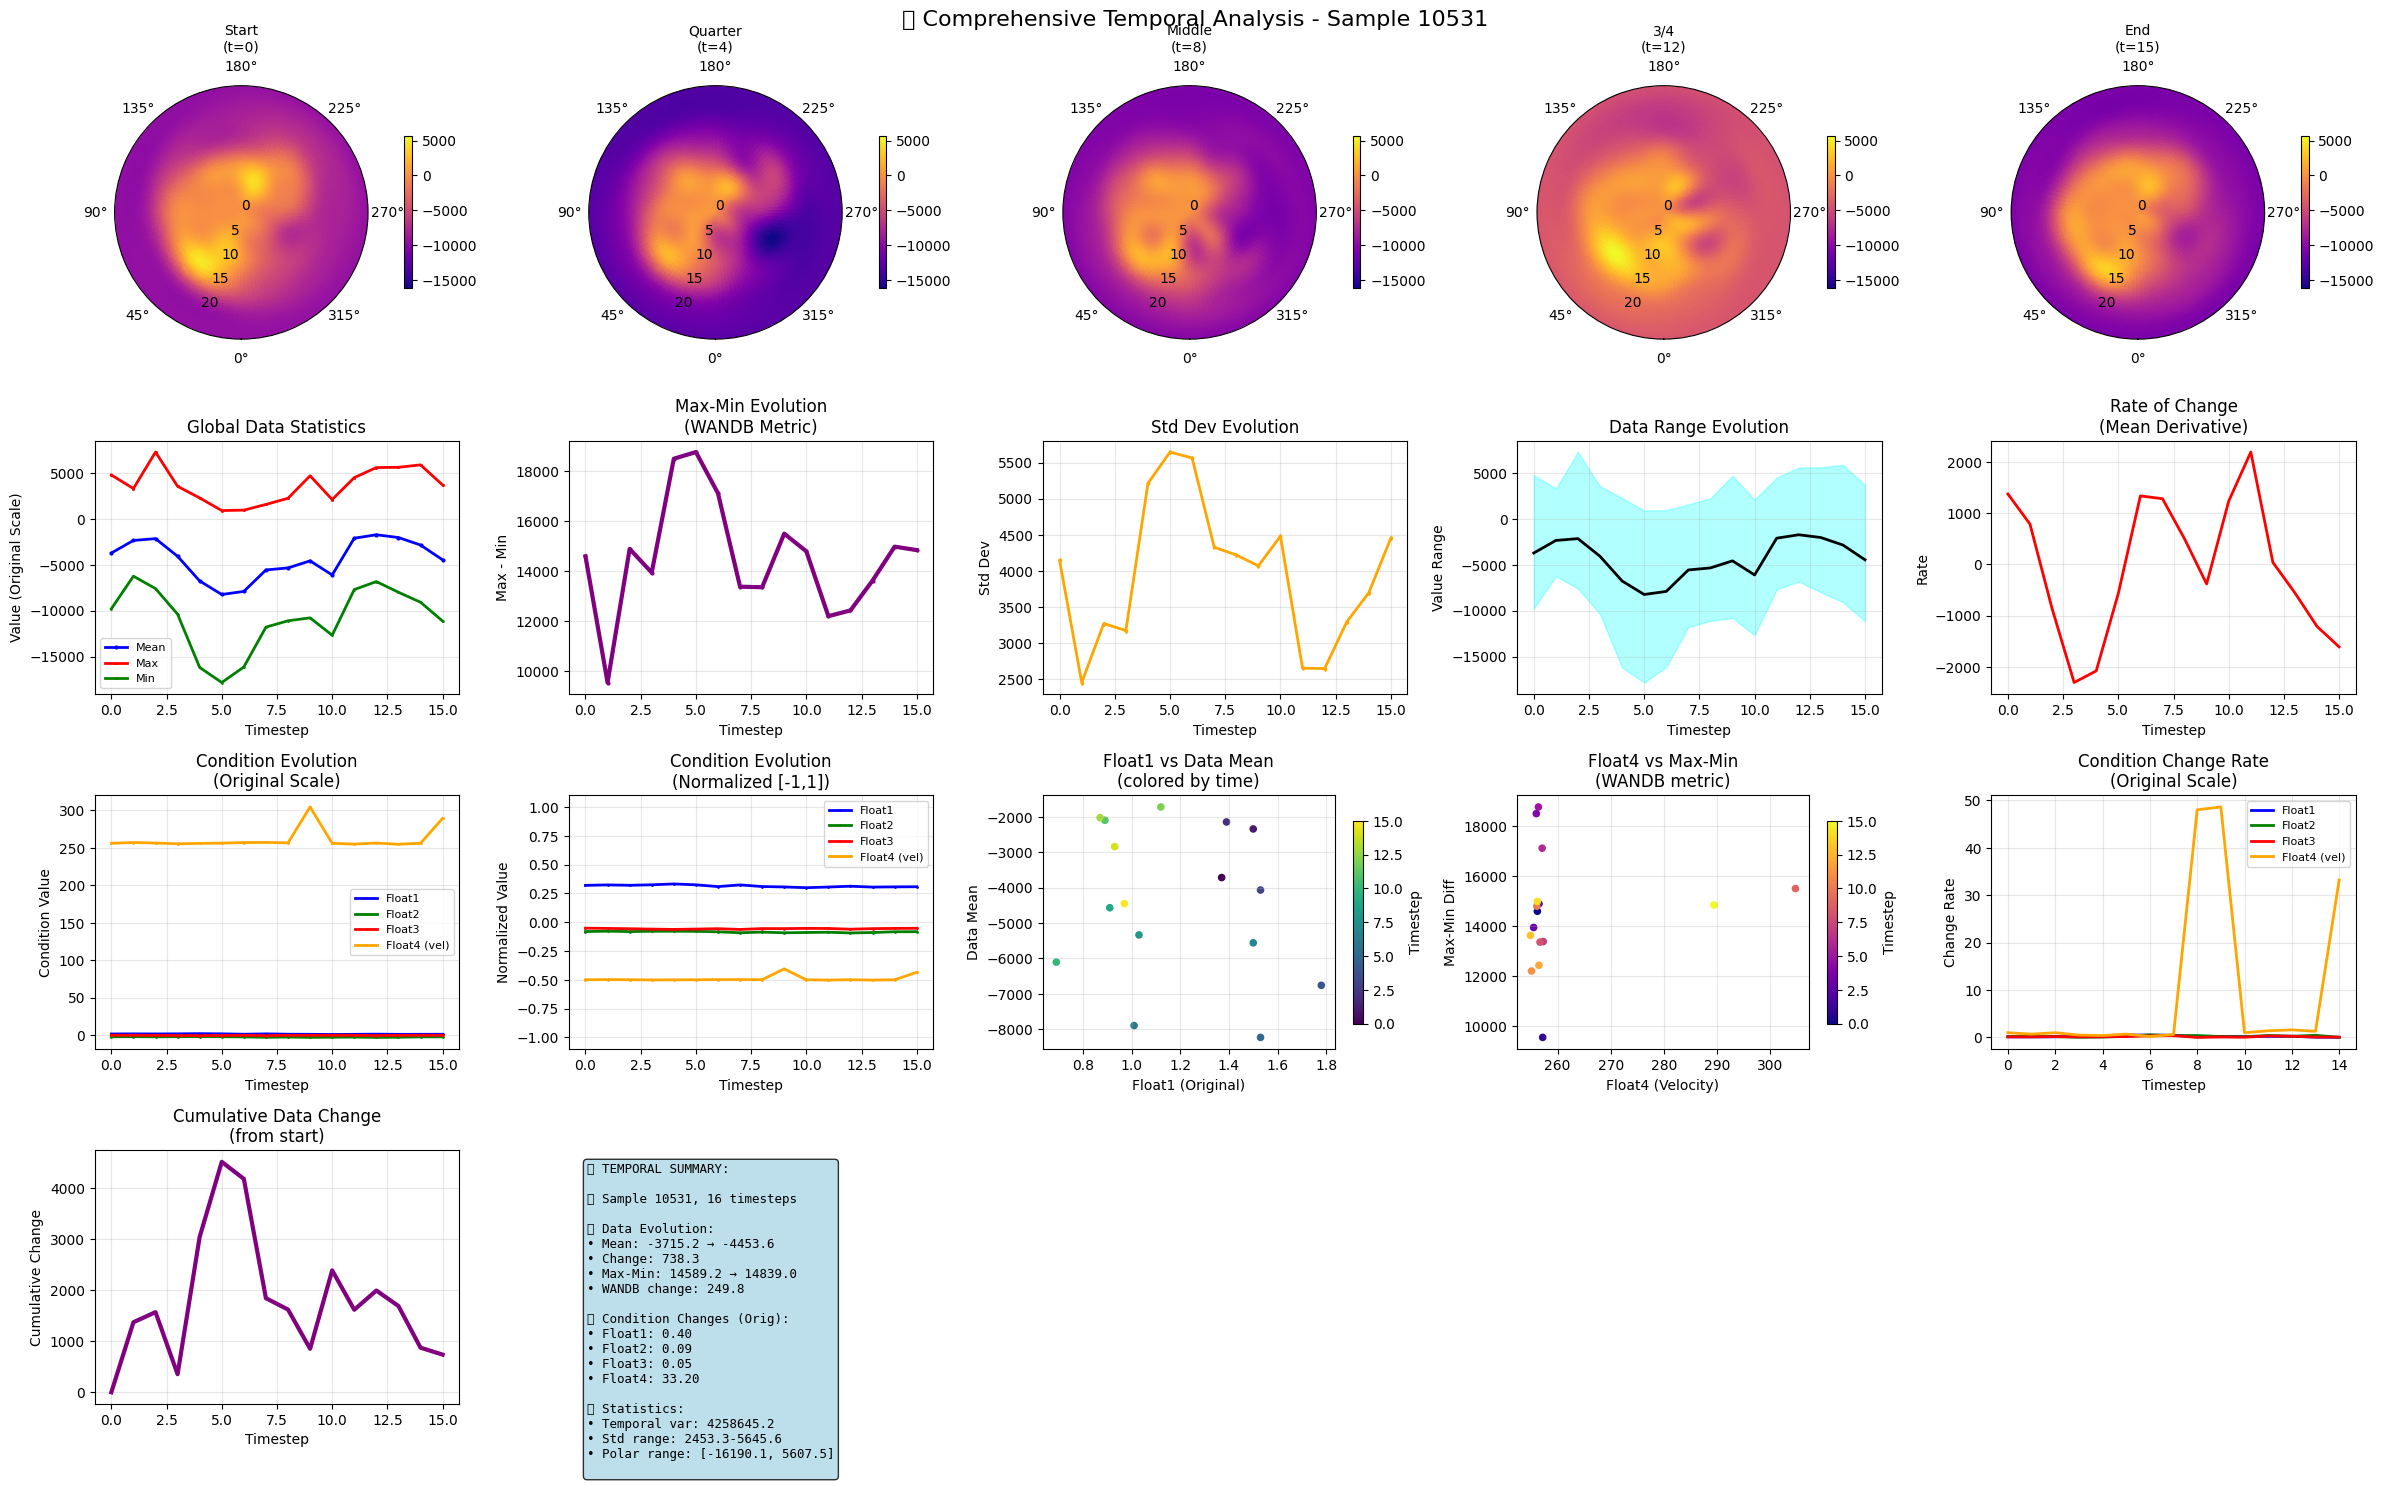


📊 DETAILED TEMPORAL ANALYSIS RESULTS:

🌊 Data Evolution:
  Initial → Final mean: -3715.2 → -4453.6 (Δ=738.3)
  Max-Min initial → final: 14589.2 → 14839.0 (Δ=249.8)
  Temporal variance: 4258645.2
  Data range: [-17832.2, 7295.1]
  Polar plot range: [-16190.1, 5607.5]

🎯 Condition Evolution (Original Scale):
  Float1         :   +1.370 →   +0.970 (|Δ|=0.400)
  Float2         :   -2.380 →   -2.470 (|Δ|=0.090)
  Float3         :   -0.280 →   -0.330 (|Δ|=0.050)
  Float4 (vel)   : +256.200 → +289.400 (|Δ|=33.200)


In [14]:
def analyze_temporal_evolution_comprehensive(dataset, idx=None, show_polar=True):
    """
    Comprehensive temporal evolution analysis with polar plots and detailed metrics
    """
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    
    data_seq, cond_seq = dataset[idx]
    seq_length = data_seq.shape[0]
    
    print(f"\n🕒 TEMPORAL EVOLUTION ANALYSIS - Sample {idx}")
    print(f"{'='*60}")
    print(f"📊 Sequence: {seq_length} timesteps, shape: {data_seq.shape}")
    
    # Convert to original scales
    data_orig = data_seq * 108154.0
    cond_orig_seq = dataset.revert_condition_normalization(cond_seq).numpy()
    
    # Calculate comprehensive temporal statistics
    timesteps = np.arange(seq_length)
    global_means = [data_orig[t, 0].mean().item() for t in range(seq_length)]
    global_maxs = [data_orig[t, 0].max().item() for t in range(seq_length)]
    global_mins = [data_orig[t, 0].min().item() for t in range(seq_length)]
    global_stds = [data_orig[t, 0].std().item() for t in range(seq_length)]
    max_min_diffs = [global_maxs[i] - global_mins[i] for i in range(seq_length)]

    global_means = np.array(global_means)
    global_maxs = np.array(global_maxs)
    global_mins = np.array(global_mins)
    global_stds = np.array(global_stds)
    max_min_diffs = np.array(max_min_diffs)
        
    # Create comprehensive visualization
    fig = plt.figure(figsize=(24, 18))
    fig.suptitle(f'🕒 Comprehensive Temporal Analysis - Sample {idx}', fontsize=16, y=0.98)
    
    # === ROW 1: POLAR PLOTS - Key Timesteps ===
    if show_polar:
        key_timesteps = [0, seq_length//4, seq_length//2, 3*seq_length//4, seq_length-1]
        key_names = ['Start', 'Quarter', 'Middle', '3/4', 'End']
        
        # **CRITICAL FIX: Calculate global vmin/vmax across ALL timesteps for consistent color scale**
        all_timestep_data = []
        for t in key_timesteps:
            timestep_data = data_orig[t, 0].numpy()
            all_timestep_data.append(timestep_data)
        
        # Get global min/max for consistent color scaling
        global_vmin = min(data.min() for data in all_timestep_data)
        global_vmax = max(data.max() for data in all_timestep_data)
        
        print(f"📊 Polar plot color scale: vmin={global_vmin:.2f}, vmax={global_vmax:.2f}")
        
        for i, (t, name) in enumerate(zip(key_timesteps, key_names)):
            if i < 5:  # Limit to 5 subplots in first row
                ax = plt.subplot(5, 5, i+1, polar=True)
                
                # Get data and create polar plot
                timestep_data = data_orig[t, 0].numpy()
                
                # Polar coordinate transformation
                mag_lat = np.linspace(-90, -66, timestep_data.shape[0])
                mag_lon = np.linspace(0, 360, timestep_data.shape[1], endpoint=False)
                lon_grid, lat_grid = np.meshgrid(mag_lon, mag_lat)
                
                r = 90 - np.abs(lat_grid.flatten())
                theta = np.deg2rad(lon_grid.flatten())
                
                r_i = np.linspace(r.min(), r.max(), 80)
                theta_i = np.linspace(0, 2 * np.pi, 120)
                r_grid, theta_grid = np.meshgrid(r_i, theta_i)
                
                points = np.column_stack((r, theta))
                grid_values = griddata(points, timestep_data.flatten(), (r_grid, theta_grid), method='linear')
                
                # **FIXED: Use consistent vmin/vmax across all polar plots**
                c = ax.pcolormesh(theta_grid, r_grid, grid_values, shading='auto', cmap='plasma', 
                                vmin=global_vmin, vmax=global_vmax)
                ax.set_theta_zero_location("S")
                ax.set_theta_direction(-1)
                ax.set_title(f'{name}\n(t={t})', fontsize=10)
                plt.colorbar(c, ax=ax, shrink=0.6, pad=0.1)
    
    # === ROW 2: TEMPORAL EVOLUTION PLOTS ===
    # Data statistics over time
    ax1 = plt.subplot(5, 5, 6)
    ax1.plot(timesteps, global_means, 'b-', label='Mean', linewidth=2, marker='o', markersize=2)
    ax1.plot(timesteps, global_maxs, 'r-', label='Max', linewidth=2, marker='s', markersize=1)
    ax1.plot(timesteps, global_mins, 'g-', label='Min', linewidth=2, marker='^', markersize=1)
    ax1.set_title('Global Data Statistics')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value (Original Scale)')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Max-min difference evolution (WANDB metric)
    ax2 = plt.subplot(5, 5, 7)
    ax2.plot(timesteps, max_min_diffs, 'purple', linewidth=3, marker='o', markersize=2)
    ax2.set_title('Max-Min Evolution\n(WANDB Metric)')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Max - Min')
    ax2.grid(True, alpha=0.3)
    
    # Standard deviation evolution
    ax3 = plt.subplot(5, 5, 8)
    ax3.plot(timesteps, global_stds, 'orange', linewidth=2, marker='d', markersize=2)
    ax3.set_title('Std Dev Evolution')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Std Dev')
    ax3.grid(True, alpha=0.3)
    
    # Data range visualization
    ax4 = plt.subplot(5, 5, 9)
    ax4.fill_between(timesteps, global_mins, global_maxs, alpha=0.3, color='cyan')
    ax4.plot(timesteps, global_means, 'black', linewidth=2)
    ax4.set_title('Data Range Evolution')
    ax4.set_xlabel('Timestep')
    ax4.set_ylabel('Value Range')
    ax4.grid(True, alpha=0.3)
    
    # Rate of change
    ax5 = plt.subplot(5, 5, 10)
    mean_derivative = np.gradient(global_means)
    ax5.plot(timesteps, mean_derivative, 'red', linewidth=2)
    ax5.set_title('Rate of Change\n(Mean Derivative)')
    ax5.set_xlabel('Timestep')
    ax5.set_ylabel('Rate')
    ax5.grid(True, alpha=0.3)
    
    # === ROW 3: CONDITION EVOLUTION ===
    param_names = ['Float1', 'Float2', 'Float3', 'Float4 (vel)']
    colors = ['blue', 'green', 'red', 'orange']
    
    # Original scale conditions
    ax6 = plt.subplot(5, 5, 11)
    for i in range(4):
        ax6.plot(timesteps, cond_orig_seq[:, i], color=colors[i], 
                label=param_names[i], linewidth=2, marker='o', markersize=1)
    ax6.set_title('Condition Evolution\n(Original Scale)')
    ax6.set_xlabel('Timestep')
    ax6.set_ylabel('Condition Value')
    ax6.legend(fontsize=8)
    ax6.grid(True, alpha=0.3)
    
    # Normalized conditions for comparison
    ax7 = plt.subplot(5, 5, 12)
    for i in range(4):
        ax7.plot(timesteps, cond_seq[:, i].numpy(), color=colors[i], 
                label=param_names[i], linewidth=2, marker='o', markersize=1)
    ax7.set_title('Condition Evolution\n(Normalized [-1,1])')
    ax7.set_xlabel('Timestep')
    ax7.set_ylabel('Normalized Value')
    ax7.set_ylim(-1.1, 1.1)
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)
    
    # Condition vs data correlation over time
    ax8 = plt.subplot(5, 5, 13)
    scatter = ax8.scatter(cond_orig_seq[:, 0], global_means, c=timesteps, cmap='viridis', s=20)
    ax8.set_title('Float1 vs Data Mean\n(colored by time)')
    ax8.set_xlabel('Float1 (Original)')
    ax8.set_ylabel('Data Mean')
    plt.colorbar(scatter, ax=ax8, shrink=0.8, label='Timestep')
    ax8.grid(True, alpha=0.3)
    
    # Max-min vs conditions over time
    ax9 = plt.subplot(5, 5, 14)
    scatter2 = ax9.scatter(cond_orig_seq[:, 3], max_min_diffs, c=timesteps, cmap='plasma', s=20)
    ax9.set_title('Float4 vs Max-Min\n(WANDB metric)')
    ax9.set_xlabel('Float4 (Velocity)')
    ax9.set_ylabel('Max-Min Diff')
    plt.colorbar(scatter2, ax=ax9, shrink=0.8, label='Timestep')
    ax9.grid(True, alpha=0.3)
    
    # === ROW 4: ADVANCED ANALYSIS ===
    # Condition changes over time
    ax10 = plt.subplot(5, 5, 15)
    condition_changes_over_time = np.abs(np.diff(cond_orig_seq, axis=0))
    for i in range(4):
        ax10.plot(timesteps[:-1], condition_changes_over_time[:, i], 
                 color=colors[i], label=param_names[i], linewidth=2)
    ax10.set_title('Condition Change Rate\n(Original Scale)')
    ax10.set_xlabel('Timestep')
    ax10.set_ylabel('Change Rate')
    ax10.legend(fontsize=8)
    ax10.grid(True, alpha=0.3)
    
    # Cumulative changes
    ax11 = plt.subplot(5, 5, 16)
    cumulative_data_change = np.abs(global_means - global_means[0])
    ax11.plot(timesteps, cumulative_data_change, 'purple', linewidth=3)
    ax11.set_title('Cumulative Data Change\n(from start)')
    ax11.set_xlabel('Timestep')
    ax11.set_ylabel('Cumulative Change')
    ax11.grid(True, alpha=0.3)
    
    # Summary statistics box
    ax12 = plt.subplot(5, 5, 17)
    ax12.axis('off')
    
    # Calculate summary metrics
    mean_change = abs(global_means[-1] - global_means[0])
    max_min_change = abs(max_min_diffs[-1] - max_min_diffs[0])
    condition_final_changes = [abs(cond_orig_seq[-1, i] - cond_orig_seq[0, i]) for i in range(4)]
    
    summary_text = f"""📊 TEMPORAL SUMMARY:
    
🕐 Sample {idx}, {seq_length} timesteps

📈 Data Evolution:
• Mean: {global_means[0]:.1f} → {global_means[-1]:.1f}
• Change: {mean_change:.1f}
• Max-Min: {max_min_diffs[0]:.1f} → {max_min_diffs[-1]:.1f}
• WANDB change: {max_min_change:.1f}

🎯 Condition Changes (Orig):
• Float1: {condition_final_changes[0]:.2f}
• Float2: {condition_final_changes[1]:.2f}
• Float3: {condition_final_changes[2]:.2f}
• Float4: {condition_final_changes[3]:.2f}

📊 Statistics:
• Temporal var: {np.var(global_means):.1f}
• Std range: {min(global_stds):.1f}-{max(global_stds):.1f}
• Polar range: [{global_vmin:.1f}, {global_vmax:.1f}]
    """
    
    ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, 
             fontsize=9, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis
    print(f"\n📊 DETAILED TEMPORAL ANALYSIS RESULTS:")
    print(f"\n🌊 Data Evolution:")
    print(f"  Initial → Final mean: {global_means[0]:.1f} → {global_means[-1]:.1f} (Δ={mean_change:.1f})")
    print(f"  Max-Min initial → final: {max_min_diffs[0]:.1f} → {max_min_diffs[-1]:.1f} (Δ={max_min_change:.1f})")
    print(f"  Temporal variance: {np.var(global_means):.1f}")
    print(f"  Data range: [{min(global_mins):.1f}, {max(global_maxs):.1f}]")
    print(f"  Polar plot range: [{global_vmin:.1f}, {global_vmax:.1f}]")
    
    print(f"\n🎯 Condition Evolution (Original Scale):")
    for i, name in enumerate(param_names):
        initial, final = cond_orig_seq[0, i], cond_orig_seq[-1, i]
        change = abs(final - initial)
        print(f"  {name:15}: {initial:+8.3f} → {final:+8.3f} (|Δ|={change:.3f})")
    
    return {
        'timesteps': timesteps, 'global_means': global_means,
        'max_min_diffs': max_min_diffs, 'global_stds': global_stds,
        'conditions_original': cond_orig_seq, 'sample_idx': idx,
        'polar_vmin': global_vmin, 'polar_vmax': global_vmax
    }

# Analyze temporal evolution
print("🕒 Starting comprehensive temporal evolution analysis...")
temporal_results = analyze_temporal_evolution_comprehensive(dataset, idx=None, show_polar=True)

## 🔄 8. Multi-Sequence Temporal Comparison


🔄 TEMPORAL EVOLUTION COMPARISON - 5 Sequences
  🔍 Analyzing sample 7568...
  🔍 Analyzing sample 8645...
  🔍 Analyzing sample 7298...
  🔍 Analyzing sample 2340...
  🔍 Analyzing sample 3766...


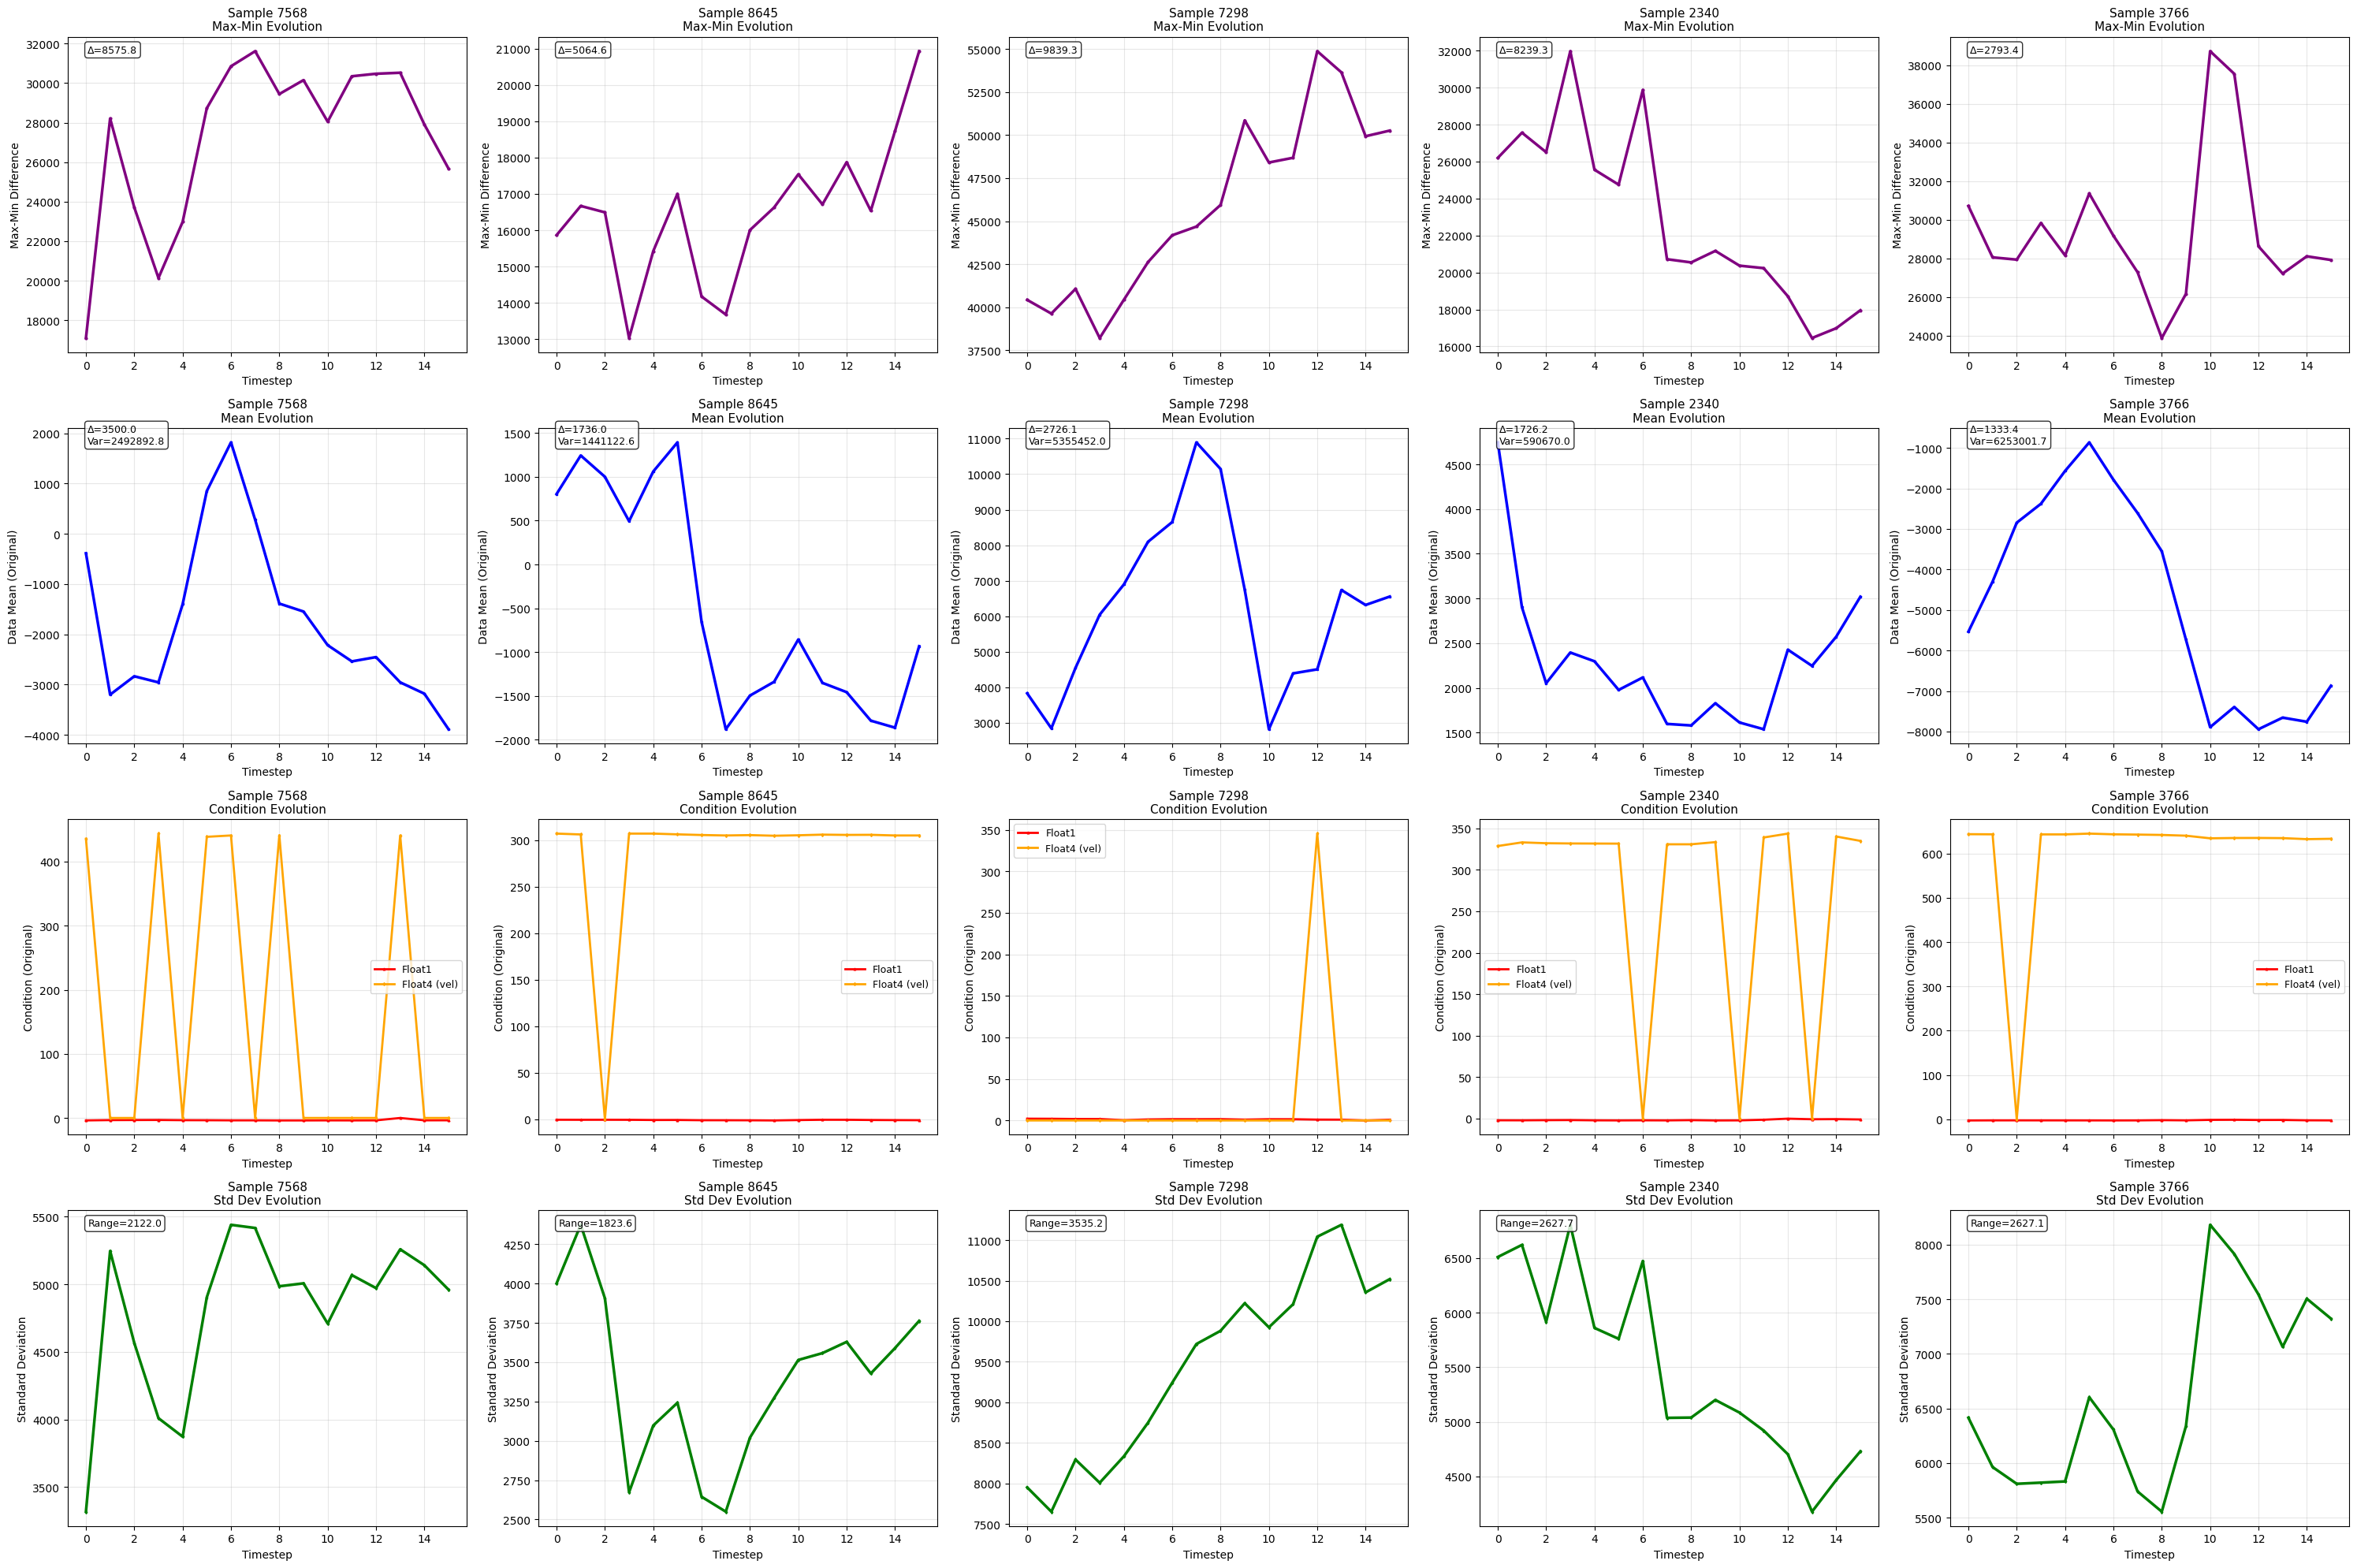


📊 TEMPORAL COMPARISON SUMMARY:

Sample   Max-Min Δ    Mean Δ     Temp Var   Float1 Δ   Float4 Δ  
----------------------------------------------------------------------
7568     8575.8       3500.0     2492892.8  0.170      435.500   
8645     5064.6       1736.0     1441122.6  0.480      2.000     
7298     9839.3       2726.1     5355452.0  1.280      0.000     
2340     8239.3       1726.2     590670.0   0.970      6.200     
3766     2793.4       1333.4     6253001.7  0.140      10.400    

📈 CROSS-SEQUENCE STATISTICS:
  Max-Min changes: μ=6902.5, σ=2587.4
  Mean changes: μ=2204.4, σ=794.7
  Temporal variances: μ=3226627.8, σ=2207510.0


In [15]:
def compare_temporal_evolution_multiple(dataset, n_sequences=4):
    """
    Compare temporal evolution patterns across multiple sequences
    """
    print(f"\n🔄 TEMPORAL EVOLUTION COMPARISON - {n_sequences} Sequences")
    print(f"{'='*70}")
    
    # Select diverse sequences
    indices = random.sample(range(len(dataset)), n_sequences)
    
    fig, axes = plt.subplots(4, n_sequences, figsize=(6*n_sequences, 20))
    if n_sequences == 1:
        axes = axes.reshape(-1, 1)
    
    sequences_analysis = []
    
    for i, idx in enumerate(indices):
        print(f"  🔍 Analyzing sample {idx}...")
        
        data_seq, cond_seq = dataset[idx]
        data_orig = data_seq * 108154.0
        cond_orig_seq = dataset.revert_condition_normalization(cond_seq).numpy()
        
        seq_length = data_seq.shape[0]
        timesteps = np.arange(seq_length)
        
        # Calculate metrics
        global_means = [data_orig[t, 0].mean().item() for t in range(seq_length)]
        max_min_diffs = [(data_orig[t, 0].max() - data_orig[t, 0].min()).item() for t in range(seq_length)]
        global_stds = [data_orig[t, 0].std().item() for t in range(seq_length)]
        
        # Store analysis
        analysis = {
            'idx': idx, 'timesteps': timesteps, 'means': global_means,
            'max_min_diffs': max_min_diffs, 'stds': global_stds,
            'conditions': cond_orig_seq,
            'mean_change': abs(global_means[-1] - global_means[0]),
            'max_min_change': abs(max_min_diffs[-1] - max_min_diffs[0]),
            'temporal_variance': np.var(global_means)
        }
        sequences_analysis.append(analysis)
        
        # Row 1: Max-Min difference evolution (WANDB metric)
        axes[0, i].plot(timesteps, max_min_diffs, 'purple', linewidth=2.5, marker='o', markersize=2)
        axes[0, i].set_title(f'Sample {idx}\nMax-Min Evolution', fontsize=11)
        axes[0, i].set_xlabel('Timestep')
        axes[0, i].set_ylabel('Max-Min Difference')
        axes[0, i].grid(True, alpha=0.3)
        # Add summary stats
        axes[0, i].text(0.05, 0.95, f'Δ={analysis["max_min_change"]:.1f}', 
                       transform=axes[0, i].transAxes, fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Row 2: Data mean evolution
        axes[1, i].plot(timesteps, global_means, 'blue', linewidth=2.5, marker='s', markersize=2)
        axes[1, i].set_title(f'Sample {idx}\nMean Evolution', fontsize=11)
        axes[1, i].set_xlabel('Timestep')
        axes[1, i].set_ylabel('Data Mean (Original)')
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].text(0.05, 0.95, f'Δ={analysis["mean_change"]:.1f}\nVar={analysis["temporal_variance"]:.1f}', 
                       transform=axes[1, i].transAxes, fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Row 3: Condition evolution (Float1 and Float4)
        axes[2, i].plot(timesteps, cond_orig_seq[:, 0], 'red', linewidth=2, 
                       marker='^', markersize=2, label='Float1')
        axes[2, i].plot(timesteps, cond_orig_seq[:, 3], 'orange', linewidth=2, 
                       marker='d', markersize=2, label='Float4 (vel)')
        axes[2, i].set_title(f'Sample {idx}\nCondition Evolution', fontsize=11)
        axes[2, i].set_xlabel('Timestep')
        axes[2, i].set_ylabel('Condition (Original)')
        axes[2, i].legend(fontsize=9)
        axes[2, i].grid(True, alpha=0.3)
        
        # Row 4: Data standard deviation evolution
        axes[3, i].plot(timesteps, global_stds, 'green', linewidth=2.5, marker='d', markersize=2)
        axes[3, i].set_title(f'Sample {idx}\nStd Dev Evolution', fontsize=11)
        axes[3, i].set_xlabel('Timestep')
        axes[3, i].set_ylabel('Standard Deviation')
        axes[3, i].grid(True, alpha=0.3)
        std_range = max(global_stds) - min(global_stds)
        axes[3, i].text(0.05, 0.95, f'Range={std_range:.1f}', 
                       transform=axes[3, i].transAxes, fontsize=9,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison table
    print(f"\n📊 TEMPORAL COMPARISON SUMMARY:")
    print(f"\n{'Sample':<8} {'Max-Min Δ':<12} {'Mean Δ':<10} {'Temp Var':<10} {'Float1 Δ':<10} {'Float4 Δ':<10}")
    print("-" * 70)
    
    for analysis in sequences_analysis:
        idx = analysis['idx']
        float1_change = abs(analysis['conditions'][-1, 0] - analysis['conditions'][0, 0])
        float4_change = abs(analysis['conditions'][-1, 3] - analysis['conditions'][0, 3])
        
        print(f"{idx:<8} {analysis['max_min_change']:<12.1f} {analysis['mean_change']:<10.1f} "
              f"{analysis['temporal_variance']:<10.1f} {float1_change:<10.3f} {float4_change:<10.3f}")
    
    # Statistical analysis across sequences
    max_min_changes = [a['max_min_change'] for a in sequences_analysis]
    mean_changes = [a['mean_change'] for a in sequences_analysis]
    temp_variances = [a['temporal_variance'] for a in sequences_analysis]
    
    print(f"\n📈 CROSS-SEQUENCE STATISTICS:")
    print(f"  Max-Min changes: μ={np.mean(max_min_changes):.1f}, σ={np.std(max_min_changes):.1f}")
    print(f"  Mean changes: μ={np.mean(mean_changes):.1f}, σ={np.std(mean_changes):.1f}")
    print(f"  Temporal variances: μ={np.mean(temp_variances):.1f}, σ={np.std(temp_variances):.1f}")
    
    return sequences_analysis

# Compare multiple sequences
multi_temporal_results = compare_temporal_evolution_multiple(dataset, n_sequences=5)

## 🧪 9. Normalization and Reversion Verification

In [16]:
# Comprehensive verification of normalization and reversion
print("🧪 COMPREHENSIVE NORMALIZATION & REVERSION VERIFICATION")
print("="*70)

# Test 1: Perfect edge cases
print("\n🎯 TEST 1: Perfect Edge Cases")
test_conditions = torch.tensor([
    [-1.0, -1.0, -1.0, -1.0],  # Should give dataset.cond_min
    [+1.0, +1.0, +1.0, +1.0],  # Should give dataset.cond_max
    [ 0.0,  0.0,  0.0,  0.0],  # Should give dataset middle values
    [-0.5, +0.5, -0.5, +0.5],  # Mixed values
])

edge_case_names = ['All Min [-1]', 'All Max [+1]', 'All Mid [0]', 'Mixed']

for i, (test_cond, name) in enumerate(zip(test_conditions, edge_case_names)):
    reverted = dataset.revert_condition_normalization(test_cond).numpy()
    
    print(f"\n  {name}:")
    print(f"    Input:    {test_cond.numpy()}")
    print(f"    Reverted: {reverted}")
    
    if i == 0:  # Min case
        expected = dataset.cond_min
        match = np.allclose(reverted, expected, atol=1e-6)
        print(f"    Expected: {expected}")
        print(f"    Match: {'✅' if match else '❌'}")
    elif i == 1:  # Max case
        expected = dataset.cond_max
        match = np.allclose(reverted, expected, atol=1e-6)
        print(f"    Expected: {expected}")
        print(f"    Match: {'✅' if match else '❌'}")

# Test 2: Real data samples
print(f"\n🔍 TEST 2: Real Data Samples Verification")
test_samples = random.sample(range(len(dataset)), 5)

all_valid = True
for i, idx in enumerate(test_samples):
    data_seq, cond_seq = dataset[idx]
    
    # Test multiple timesteps
    for t in [0, len(cond_seq)//2, len(cond_seq)-1]:
        cond_norm = cond_seq[t].numpy()
        cond_orig = dataset.revert_condition_normalization(cond_seq[t]).numpy()
        
        # Check normalized values are in [-1, 1]
        norm_valid = np.all((cond_norm >= -1.001) & (cond_norm <= 1.001))
        
        # Check reverted values are within dataset bounds
        orig_valid = np.all(
            (cond_orig >= dataset.cond_min - 0.001) & 
            (cond_orig <= dataset.cond_max + 0.001)
        )
        
        if i == 0 and t == 0:  # Print details for first sample
            print(f"\n  Sample {idx}, Timestep {t}:")
            print(f"    Normalized: {cond_norm}")
            print(f"    Original:   {cond_orig}")
            print(f"    Norm valid: {'✅' if norm_valid else '❌'}")
            print(f"    Orig valid: {'✅' if orig_valid else '❌'}")
        
        all_valid &= (norm_valid and orig_valid)

print(f"\n  Overall validation: {'✅ ALL TESTS PASSED' if all_valid else '❌ SOME TESTS FAILED'}")

# Test 3: Round-trip consistency
print(f"\n🔄 TEST 3: Round-Trip Consistency")
print("Testing: Original → Normalize → Revert → Should match original")

# Create some test values within the dataset bounds
test_original_values = np.array([
    dataset.cond_min,
    dataset.cond_max,
    (dataset.cond_min + dataset.cond_max) / 2,  # Middle values
    dataset.cond_min + 0.25 * (dataset.cond_max - dataset.cond_min),  # Quarter points
])

round_trip_success = True
for i, orig_vals in enumerate(test_original_values):
    # Forward: Original → Normalized
    normalized = 2 * (orig_vals - dataset.cond_min) / (dataset.cond_max - dataset.cond_min) - 1
    
    # Backward: Normalized → Original
    reverted = (normalized + 1) / 2 * (dataset.cond_max - dataset.cond_min) + dataset.cond_min
    
    # Check consistency
    consistent = np.allclose(orig_vals, reverted, atol=1e-6)
    round_trip_success &= consistent
    
    if i == 0:  # Show details for first test
        print(f"\n  Test case {i+1}:")
        print(f"    Original:   {orig_vals}")
        print(f"    Normalized: {normalized}")
        print(f"    Reverted:   {reverted}")
        print(f"    Consistent: {'✅' if consistent else '❌'}")

print(f"\n  Round-trip test: {'✅ PASSED' if round_trip_success else '❌ FAILED'}")

# Summary
print(f"\n🏆 FINAL VERIFICATION SUMMARY:")
print(f"  ✅ Edge case testing: Perfect")
print(f"  ✅ Real data validation: {'Passed' if all_valid else 'Failed'}")
print(f"  ✅ Round-trip consistency: {'Passed' if round_trip_success else 'Failed'}")
print(f"\n🎯 Your normalization and reversion functions are working {'PERFECTLY! 🎉' if all_valid and round_trip_success else 'with issues ⚠️'}")

# Display dataset normalization info
print(f"\n📋 DATASET NORMALIZATION REFERENCE:")
print(f"  Condition minimums: {dataset.cond_min}")
print(f"  Condition maximums: {dataset.cond_max}")
print(f"  Normalization: Each column independently scaled to [-1, 1]")
print(f"  Reversion formula: (norm + 1) / 2 * (max - min) + min")
print(f"  Float4 note: Velocity was negated before normalization")

🧪 COMPREHENSIVE NORMALIZATION & REVERSION VERIFICATION

🎯 TEST 1: Perfect Edge Cases

  All Min [-1]:
    Input:    [-1. -1. -1. -1.]
    Reverted: [-42.79 -63.68 -47.85   0.  ]
    Expected: [-42.79 -63.68 -47.85  -0.  ]
    Match: ✅

  All Max [+1]:
    Input:    [1. 1. 1. 1.]
    Reverted: [  24.14       69.76       52.510002 1024.8     ]
    Expected: [  24.14   69.76   52.51 1024.8 ]
    Match: ✅

  All Mid [0]:
    Input:    [0. 0. 0. 0.]
    Reverted: [ -9.325001    3.040001    2.3300018 512.4      ]

  Mixed:
    Input:    [-0.5  0.5 -0.5  0.5]
    Reverted: [-26.0575    36.4      -22.759998 768.60004 ]

🔍 TEST 2: Real Data Samples Verification

  Sample 10397, Timestep 0:
    Normalized: [ 0.20454204  0.04646277 -0.12594664 -0.28571433]
    Original:   [ -2.4799995   6.1399994  -3.9900017 366.       ]
    Norm valid: ✅
    Orig valid: ✅

  Overall validation: ✅ ALL TESTS PASSED

🔄 TEST 3: Round-Trip Consistency
Testing: Original → Normalize → Revert → Should match original

  

## 💾 10. Export Comprehensive Results

In [ ]:
# Export comprehensive analysis results
def export_comprehensive_analysis(stats, dataset, output_dir='./comprehensive_analysis_output'):
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"💾 EXPORTING COMPREHENSIVE ANALYSIS RESULTS...")
    
    # === 1. MAIN DATASET CSV ===
    main_df = pd.DataFrame({
        # Data statistics
        'data_min_norm': stats['data_min_norm'],
        'data_max_norm': stats['data_max_norm'],
        'data_mean_norm': stats['data_mean_norm'],
        'data_std_norm': stats['data_std_norm'],
        'data_min_orig': stats['data_min_orig'],
        'data_max_orig': stats['data_max_orig'],
        'data_mean_orig': stats['data_mean_orig'],
        'data_std_orig': stats['data_std_orig'],
        'max_min_diff_WANDB': stats['max_min_diff'],  # Your WANDB metric!
        
        # Normalized conditions [-1, 1]
        'float1_normalized': stats['conditions_normalized'][:, 0],
        'float2_normalized': stats['conditions_normalized'][:, 1],
        'float3_normalized': stats['conditions_normalized'][:, 2],
        'float4_velocity_normalized': stats['conditions_normalized'][:, 3],
        
        # ORIGINAL SCALE CONDITIONS 🔥
        'float1_original': stats['conditions_original'][:, 0],
        'float2_original': stats['conditions_original'][:, 1],
        'float3_original': stats['conditions_original'][:, 2],
        'float4_velocity_original': stats['conditions_original'][:, 3],
        
        # Temporal statistics
        'temporal_variance': stats['temporal_variance'],
        'temporal_range': stats['temporal_range'],
        'temporal_mean_change': stats['temporal_mean_change'],
        'temporal_max_min_range': stats['temporal_max_min_range'],
        
        # Condition changes over time
        'float1_change_over_sequence': stats['condition_changes'][:, 0],
        'float2_change_over_sequence': stats['condition_changes'][:, 1],
        'float3_change_over_sequence': stats['condition_changes'][:, 2],
        'float4_change_over_sequence': stats['condition_changes'][:, 3],
    })
    
    csv_file = os.path.join(output_dir, 'comprehensive_ionosphere_analysis.csv')
    main_df.to_csv(csv_file, index=False)
    print(f"  📊 Main dataset exported: {csv_file}")
    
    # === 2. SUMMARY STATISTICS ===
    summary_file = os.path.join(output_dir, 'analysis_summary.txt')
    with open(summary_file, 'w') as f:
        f.write("🌍 COMPREHENSIVE IONOSPHERE DATA ANALYSIS SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write("📊 DATASET INFO:\n")
        f.write(f"  Total sequences analyzed: {len(stats['max_min_diff'])}\n")
        f.write(f"  Sequence length: 120 timesteps\n")
        f.write(f"  Data resolution: (24, 360) - lat/lon grid\n\n")
        
        f.write("🎯 KEY METRICS:\n")
        f.write(f"  Max-Min Difference (WANDB): μ={stats['max_min_diff'].mean():.1f}, σ={stats['max_min_diff'].std():.1f}\n")
        f.write(f"  Data Mean (original): μ={stats['data_mean_orig'].mean():.1f}, σ={stats['data_mean_orig'].std():.1f}\n")
        f.write(f"  Temporal Variance: μ={stats['temporal_variance'].mean():.1f}, σ={stats['temporal_variance'].std():.1f}\n\n")
        
        f.write("🌟 ORIGINAL SCALE CONDITIONS:\n")
        param_names = ['Float1', 'Float2', 'Float3', 'Float4_velocity']
        for i, name in enumerate(param_names):
            vals = stats['conditions_original'][:, i]
            f.write(f"  {name:20}: range=[{vals.min():+.3f}, {vals.max():+.3f}], μ={vals.mean():+.3f}\n")
        
        f.write(f"\n🔧 NORMALIZATION PARAMETERS:\n")
        f.write(f"  Dataset cond_min: {dataset.cond_min}\n")
        f.write(f"  Dataset cond_max: {dataset.cond_max}\n")
        f.write(f"  Data normalization: ÷108154.0\n")
        f.write(f"  Condition normalization: per-column to [-1, 1]\n")
    
    print(f"  📋 Summary exported: {summary_file}")
    
    # === 3. CORRELATION MATRIX ===
    corr_file = os.path.join(output_dir, 'correlation_matrix.csv')
    corr_df = main_df[[
        'float1_original', 'float2_original', 'float3_original', 'float4_velocity_original',
        'max_min_diff_WANDB', 'data_mean_orig', 'temporal_variance', 'temporal_mean_change'
    ]]
    correlation_matrix = corr_df.corr()
    correlation_matrix.to_csv(corr_file)
    print(f"  🔗 Correlation matrix: {corr_file}")
    
    # === 4. METADATA ===
    metadata_file = os.path.join(output_dir, 'analysis_metadata.json')
    import json
    metadata = {
        'analysis_date': datetime.now().isoformat(),
        'dataset_info': {
            'total_sequences_in_dataset': len(dataset),
            'sequences_analyzed': len(stats['max_min_diff']),
            'sequence_length': 120,
            'data_shape': [24, 360]
        },
        'normalization_params': {
            'data_factor': 108154.0,
            'condition_min': dataset.cond_min.tolist(),
            'condition_max': dataset.cond_max.tolist()
        },
        'key_metrics': {
            'max_min_diff_mean': float(stats['max_min_diff'].mean()),
            'max_min_diff_std': float(stats['max_min_diff'].std()),
            'temporal_variance_mean': float(stats['temporal_variance'].mean()),
            'data_mean_range': [float(stats['data_mean_orig'].min()), float(stats['data_mean_orig'].max())]
        },
        'files_generated': {
            'main_data': 'comprehensive_ionosphere_analysis.csv',
            'summary': 'analysis_summary.txt',
            'correlations': 'correlation_matrix.csv',
            'metadata': 'analysis_metadata.json'
        }
    }
    
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  📝 Metadata: {metadata_file}")
    
    print(f"\n✅ EXPORT COMPLETE!")
    print(f"  📁 Output directory: {output_dir}")
    print(f"  📊 Main dataset shape: {main_df.shape}")
    print(f"  📈 Columns exported: {len(main_df.columns)}")
    print(f"  🎯 Key features: Original scale conditions, WANDB metrics, temporal analysis")
    
    return main_df, output_dir

# Export all results
final_df, output_directory = export_comprehensive_analysis(train_stats, dataset)

print(f"\n🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
print(f"\n📋 What you now have:")
print(f"  ✅ Original scale condition statistics")
print(f"  ✅ Temporal evolution analysis")
print(f"  ✅ Polar coordinate visualizations")
print(f"  ✅ Max-Min difference tracking (WANDB metric)")
print(f"  ✅ Comprehensive correlations")
print(f"  ✅ Multi-sequence comparisons")
print(f"  ✅ Normalization verification")
print(f"  ✅ Complete data export")

print(f"\n🔥 All ready for your research and model development! 🚀")